In [1]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
# Neural Network lib
from tensorflow.keras.layers import Dense, Embedding, Dropout, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional, SpatialDropout1D ,ELU
from tensorflow.keras.layers import BatchNormalization, Dropout ,Conv1D,GlobalMaxPooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow.keras as keras
import pickle

In [2]:
df = pd.read_csv("IMDB Dataset.csv")
df=df.sample(n=35000,random_state=42)

In [3]:
def styled_heading(text, background_color='#0077b6', text_color='white'):
    return f"""
    <p style="
        background-color: {background_color};
        font-family: Arial, sans-serif;
        font-size: 20px;
        font-weight: bold;
        color: {text_color};
        text-align: center;
        border-radius: 8px;
        padding: 12px;
        box-shadow: 2px 2px 5px rgba(0, 0, 0, 0.2);
        width: fit-content;
        margin: 10px auto;
    ">
        {text}
    </p>
    """
def style_table(df):
    return df.style.set_table_styles([
        {"selector": "th", "props": [("color", "white"), ("background-color", "#0077b6"), ("padding", "10px")]},
        {"selector": "td", "props": [("text-align", "center"), ("padding", "8px")]} 
    ]).set_properties(**{"border": "1px solid #ddd"}).hide(axis="index").to_html()

def print_dataset_analysis(df, n_top=5, heading_color='#0077b6', text_color='white'):
    display(HTML(styled_heading("📊 Basic Overview of Data", heading_color, text_color)))
    display(HTML(style_table(df.head(n_top))))
    
    display(HTML(styled_heading("🚫 Missing Values", heading_color, text_color)))
    null_counts = df.isnull().sum()
    if null_counts.sum() == 0:
        display(HTML("<p style='text-align:center; font-weight:bold;'>✅ No missing values in the dataset.</p>"))
    else:
        display(HTML(style_table(null_counts[null_counts > 0].to_frame(name='Missing Count'))))
    
    display(HTML(styled_heading("♻️ Duplicate Records", heading_color, text_color)))
    duplicates = df.duplicated().sum()
    display(HTML(f"<p style='text-align:center; font-weight:bold;'>🔄 {duplicates} duplicate rows found.</p>"))
    
    display(HTML(styled_heading("📏 Dataset Shape", heading_color, text_color)))
    display(HTML(f"<p style='text-align:center; font-weight:bold;'>Rows: {df.shape[0]}, Columns: {df.shape[1]}</p>"))

def print_value_counts(df, target_column, heading_color='#0077b6', text_color='white'):
    display(HTML(styled_heading("🔢 Value Counts", heading_color, text_color)))
    if target_column in df.columns:
        value_counts = df[target_column].value_counts()
        formatted_counts = "".join(f"<p style='text-align:center; font-weight:bold;'>{index}: {count}</p>" for index, count in value_counts.items())
        display(HTML(formatted_counts))
    else:
        display(HTML(f"<p style='text-align:center; font-weight:bold; color:red;'>⚠️ Column '{target_column}' not found in dataset.</p>"))

print_dataset_analysis(df,n_top=5)
print_value_counts(df,'sentiment')

review,sentiment
"I really liked this Summerslam due to the look of the arena, the curtains and just the look overall was interesting to me for some reason. Anyways, this could have been one of the best Summerslam's ever if the WWF didn't have Lex Luger in the main event against Yokozuna, now for it's time it was ok to have a huge fat man vs a strong man but I'm glad times have changed. It was a terrible main event just like every match Luger is in is terrible. Other matches on the card were Razor Ramon vs Ted Dibiase, Steiner Brothers vs Heavenly Bodies, Shawn Michaels vs Curt Hening, this was the event where Shawn named his big monster of a body guard Diesel, IRS vs 1-2-3 Kid, Bret Hart first takes on Doink then takes on Jerry Lawler and stuff with the Harts and Lawler was always very interesting, then Ludvig Borga destroyed Marty Jannetty, Undertaker took on Giant Gonzalez in another terrible match, The Smoking Gunns and Tatanka took on Bam Bam Bigelow and the Headshrinkers, and Yokozuna defended the world title against Lex Luger this match was boring and it has a terrible ending. However it deserves 8/10",positive
"Not many television shows appeal to quite as many different kinds of fans like Farscape does...I know youngsters and 30/40+ years old;fans both Male and Female in as many different countries as you can think of that just adore this T.V miniseries. It has elements that can be found in almost every other show on T.V, character driven drama that could be from an Australian soap opera; yet in the same episode it has science fact & fiction that would give even the hardiest ""Trekkie"" a run for his money in the brainbender stakes! Wormhole theory, Time Travel in true equational form...Magnificent. It embraces cultures from all over the map as the possibilities are endless having multiple stars and therefore thousands of planets to choose from.With such a broad scope; it would be expected that nothing would be able to keep up the illusion for long, but here is where ""Farscape"" really comes into it's own element...It succeeds where all others have failed, especially the likes of Star Trek (a universe with practically zero Kaos element!) They ran out of ideas pretty quickly + kept rehashing them! Over the course of 4 seasons they manage to keep the audience's attention using good continuity and constant character evolution with multiple threads to every episode with unique personal touches to camera that are specific to certain character groups within the whole. This structure allows for an extremely large area of subject matter as loyalties are forged and broken in many ways on many many issues. I happened to see the pilot (Premiere) in passing and just had to keep tuning in after that to see if Crichton would ever ""Get the girl"", after seeing them all on television I was delighted to see them available on DVD & I have to admit that it was the only thing that kept me sane whilst I had to do a 12 hour night shift and developed chronic insomnia...Farscape was the only thing to get me through those extremely long nights...Do yourself a favour; Watch the pilot and see what I mean...Farscape Comet",positive
"The film quickly gets to a major chase scene with ever increasing destruction. The first really bad thing is the guy hijacking Steven Seagal would have been beaten to pulp by Seagal's driving, but that probably would have ended the whole premise for the movie.It seems like they decided to make all kinds of changes in the movie plot, so just plan to enjoy the action, and do not expect a coherent plot. Turn any sense of logic you may have, it will reduce your chance of getting a headache.I does give me some hope that Steven Seagal is trying to move back towards the type of characters he portrayed in his more popular movies.",negative
"Jane Austen would definitely approve of this one!Gwyneth Paltrow does an awesome job capturing the attitude of Emma. She is funny without being excessively silly, yet elegant. She puts o

In [4]:
df=df.drop_duplicates()

In [5]:
# stop words to be removed later
custom_stopwords = set(stopwords.words('english'))  
# Make sure 'review' is a valid column name
print(df.columns)

Index(['review', 'sentiment'], dtype='object')


In [6]:
def preprocess_text(text):
    if isinstance(text, str):  # Ensure text is a string
        ## REMOVE HTML
        if "<" in text and ">" in text:
            text = BeautifulSoup(text, "html.parser").get_text()
        ## CLEANING
        # Remove special characters
        text = re.sub(r'\W+', ' ', text)  
        # Remove digits
        text = re.sub(r'\d+', '', text)
        ## LOWERCASING
        text = text.lower()
        ## TOKENIZATION
        words = text.split()
        ## REMOVE STOPWORDS
        words = [w for w in words if w not in custom_stopwords] 
        ## APPLY LEMMATIZATION
        words = [lemmatizer.lemmatize(w) for w in words]
        ## RETURN CLEANED TEXT
        return ' '.join(words)
    return ""
# Apply preprocessing
df['processed_review'] = df['review'].apply(preprocess_text)
# Show original vs processed text
print(df[['review', 'processed_review']].head(10))  

                                                  review  \
33553  I really liked this Summerslam due to the look...   
9427   Not many television shows appeal to quite as m...   
199    The film quickly gets to a major chase scene w...   
12447  Jane Austen would definitely approve of this o...   
39489  Expectations were somewhat high for me when I ...   
42724  I've watched this movie on a fairly regular ba...   
10822  For once a story of hope highlighted over the ...   
49498  Okay, I didn't get the Purgatory thing the fir...   
4144   I was very disappointed with this series. It h...   
36958  The first 30 minutes of Tinseltown had my fing...   

                                        processed_review  
33553  really liked summerslam due look arena curtain...  
9427   many television show appeal quite many differe...  
199    film quickly get major chase scene ever increa...  
12447  jane austen would definitely approve one gwyne...  
39489  expectation somewhat high went see mo

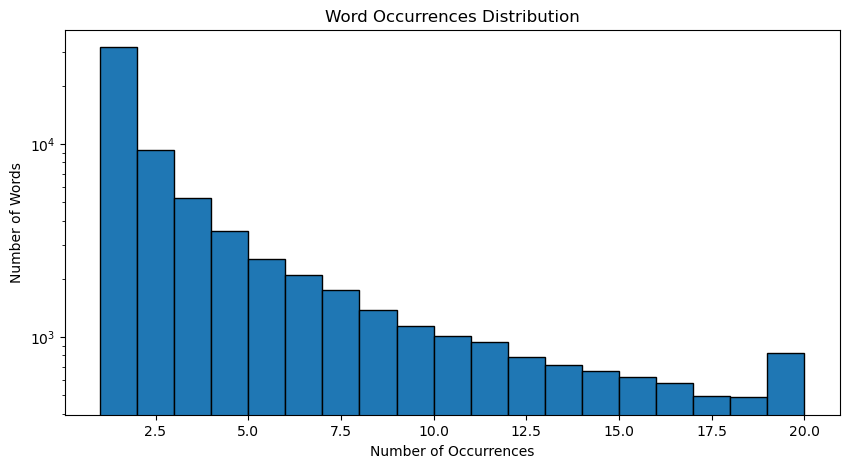

In [7]:
# BAG OF WORDS ASSUMPTION
word_counts = Counter(" ".join(df["processed_review"]).split())
# Get word frequencies
occurrences_values = list(word_counts.values())

# Plot histogram to help decide the threshold that will be used to remove rare words later
# threshold here is the minimum number of occurrences for one word so that it will not be considered as a rare word
plt.figure(figsize=(10, 5))
plt.hist(occurrences_values, bins=range(1, 21), edgecolor='black')  # Only show words appearing ≤ 20 times 
plt.yscale('log')  # Log scale helps visualize better
plt.xlabel("Number of Occurrences")
plt.ylabel("Number of Words")
plt.title("Word Occurrences Distribution")
plt.show()

In [8]:
## REMOVE RARE WORDS
# Most words appear very few times (1-5 occurrences)
# The count drops significantly as frequency increases  
# we will take a threshold of 4 which Keeps moderately rare words that might still carry meaning but Removes very infrequent words that could add noise

threshold = 4
# Identify rare words
rare_words = {w for w, c in word_counts.items() if c <= threshold}  

def remove_rare_words(text):
    if isinstance(text, str):  # Ensure text is a string
        words = text.split()
        return ' '.join([w for w in words if w not in rare_words])
    return ""

# Apply to dataset
df['processed_review2'] = df['processed_review'].apply(remove_rare_words)

# Check results
print(df[['processed_review', 'processed_review2']].head(10))

                                        processed_review  \
33553  really liked summerslam due look arena curtain...   
9427   many television show appeal quite many differe...   
199    film quickly get major chase scene ever increa...   
12447  jane austen would definitely approve one gwyne...   
39489  expectation somewhat high went see movie thoug...   
42724  watched movie fairly regular basis life never ...   
10822  story hope highlighted tragic reality youth fa...   
49498  okay get purgatory thing first time watched ep...   
4144   disappointed series lot cool graphic level det...   
36958  first minute tinseltown finger teetering remot...   

                                       processed_review2  
33553  really liked summerslam due look arena curtain...  
9427   many television show appeal quite many differe...  
199    film quickly get major chase scene ever increa...  
12447  jane austen would definitely approve one gwyne...  
39489  expectation somewhat high went see mo

In [9]:
df.loc[df['sentiment'] == 'positive', 'sentiment'] = 1
df.loc[df['sentiment'] == 'negative', 'sentiment'] = 0
df.head()

,review,sentiment,processed_review,processed_review2
33553,I really liked this Summerslam due to the look...,1,really liked summerslam due look arena curtain...,really liked summerslam due look arena curtain...
9427,Not many television shows appeal to quite as m...,1,many television show appeal quite many differe...,many television show appeal quite many differe...
199,The film quickly gets to a major chase scene w...,0,film quickly get major chase scene ever increa...,film quickly get major chase scene ever increa...
12447,Jane Austen would definitely approve of this o...,1,jane austen would definitely approve one gwyne...,jane austen would definitely approve one gwyne...
39489,Expectations were somewhat high for me when I ...,0,expectation somewhat high went see movie thoug...,expectation somewhat high went see movie thoug...


In [10]:
X = df['processed_review2']  
y = df['sentiment']

In [11]:
y = np.array(y, dtype=np.int32)
label = np.eye(2, dtype=np.float32)[y]
label[0]

array([0., 1.], dtype=float32)

In [12]:
tokenize = Tokenizer()
tokenize.fit_on_texts(X)

with open("tokenizer.pkl", "wb") as handle:
    pickle.dump(tokenize, handle, protocol=pickle.HIGHEST_PROTOCOL)

token_sequance = tokenize.texts_to_sequences(X)
max_sentince_size = max(len(i) for i in token_sequance)
pad_data = pad_sequences(token_sequance, maxlen=max_sentince_size, padding='pre')

print('The max sentence size is:', max_sentince_size)
print('The shape of padding data:', pad_data.shape)

The max sentence size is: 1128
The shape of padding data: (34785, 1128)


In [13]:
voc_size = len(tokenize.word_index) + 1
print('Max vocab size : ', voc_size)

Max vocab size :  29908


In [14]:
X_train, X_test, y_train, y_test = train_test_split(pad_data, label, test_size=0.2, random_state=42)

print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))

Training set size: 27828
Testing set size: 6957


In [ ]:
model = keras.models.Sequential([
    Embedding(input_dim=voc_size, output_dim=max_sentince_size, input_length=max_sentince_size, mask_zero=True),
    SpatialDropout1D(0.3),
    GlobalAveragePooling1D(),
    Dropout(0.5),
    Dense(2, activation="softmax", kernel_regularizer=l2(0.001))
])

model.build(input_shape=(None, max_sentince_size))
model.compile(optimizer=Adam(learning_rate=0.0005), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss', patience=2)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=1, min_lr=0.00001)
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=0)

In [17]:
history = model.fit(X_train, y_train, callbacks=[early_stop,reduce_lr,checkpoint], epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
870/870 ━━━━━━━━━━━━━━━━━━━━ 929s 1s/step - accuracy: 0.8080 - loss: 0.5342 - val_accuracy: 0.8869 - val_loss: 0.3317 - learning_rate: 5.0000e-04
Epoch 2/20
870/870 ━━━━━━━━━━━━━━━━━━━━ 962s 1s/step - accuracy: 0.9163 - loss: 0.2880 - val_accuracy: 0.8922 - val_loss: 0.3089 - learning_rate: 5.0000e-04
Epoch 3/20
870/870 ━━━━━━━━━━━━━━━━━━━━ 901s 1s/step - accuracy: 0.9369 - loss: 0.2439 - val_accuracy: 0.8967 - val_loss: 0.3015 - learning_rate: 5.0000e-04
Epoch 4/20
870/870 ━━━━━━━━━━━━━━━━━━━━ 910s 1s/step - accuracy: 0.9510 - loss: 0.2118 - val_accuracy: 0.8982 - val_loss: 0.2994 - learning_rate: 5.0000e-04
Epoch 5/20
870/870 ━━━━━━━━━━━━━━━━━━━━ 874s 1s/step - accuracy: 0.9589 - loss: 0.1933 - val_accuracy: 0.8968 - val_loss: 0.3007 - learning_rate: 5.0000e-04
Epoch 6/20
870/870 ━━━━━━━━━━━━━━━━━━━━ 918s 999ms/step - accuracy: 0.9660 - loss: 0.1737 - val_accuracy: 0.8965 - val_loss: 0.3013 - learning_rate: 1.5000e-04


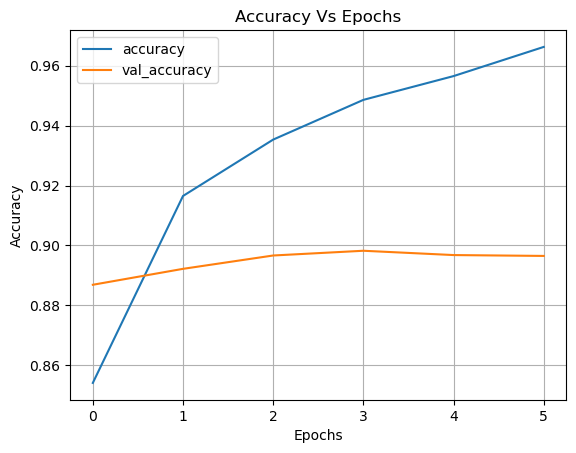

In [40]:
plt.plot(history.history["accuracy"] , label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Accuracy Vs Epochs")

plt.legend()
plt.grid()

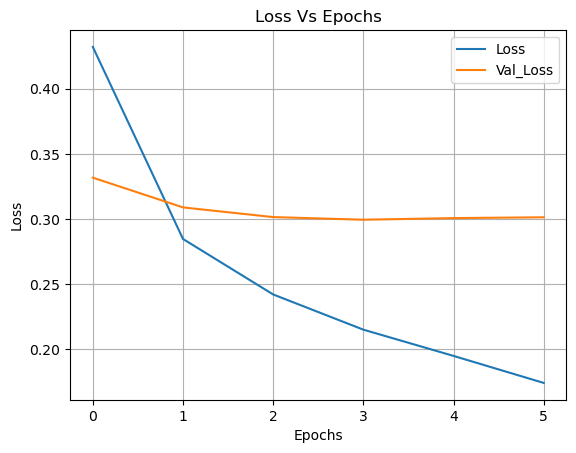

In [42]:
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Val_Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.title("Loss Vs Epochs")

plt.legend()
plt.grid()

In [20]:
from tensorflow.keras.models import load_model

best_model = load_model("best_model.keras")
best_model.evaluate(X_test, y_test)

218/218 ━━━━━━━━━━━━━━━━━━━━ 28s 121ms/step - accuracy: 0.9017 - loss: 0.3008


[0.2994433343410492, 0.8982319831848145]

In [31]:
token_sequance = tokenize.texts_to_sequences(X[:10])  # تحويل أول 10 جمل إلى تسلسل
max_sentince_size = max(len(i) for i in token_sequance)  # تحديد طول الجمل بعد تحويلها

# تعبئة البيانات لتصبح بنفس الحجم
pad_data = pad_sequences(token_sequance, maxlen=max_sentince_size, padding='pre')

# عرض الحجم للتأكد
print('The shape of padding data:', pad_data.shape)

The shape of padding data: (10, 305)


In [39]:
predictions = best_model.predict(pad_data)

# عرض النتائج
for i, prediction in enumerate(predictions):
    sentiment = "Positive" if prediction[1] > 0.5 else "Negative"
    print(f"Review {i+1}: {X.iloc[i]}")  # استخدم iloc للوصول للجمل من الـ DataFrame
    print(f"Predicted Sentiment: {sentiment}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Review 1: really liked summerslam due look arena curtain look overall interesting reason anyways could one best summerslam ever wwf lex luger main event yokozuna time ok huge fat man v strong man glad time changed terrible main event like every match luger terrible match card razor ramon v ted dibiase steiner brother v heavenly body shawn michael v curt event shawn named big monster body guard diesel irs v kid bret hart first take doink take jerry lawler stuff hart lawler always interesting destroyed marty undertaker took giant gonzalez another terrible match smoking tatanka took bam bam bigelow yokozuna defended world title lex luger match boring terrible ending however deserves
Predicted Sentiment: Positive

Review 2: many television show appeal quite many different kind fan like farscape know youngster year old fan male female many different country think adore v miniseries element found almost every show v character driven drama could australi